# Load Modules

## import modules

In [44]:
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = 'Arial'
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
%matplotlib inline

## load data function

In [2]:
def load_data_suffixes(file_pairs, src_dir='', dst_dir='.', suffixes=None):
    import os
    if not os.path.isdir(dst_dir):
        os.mkdir(dst_dir)
    if not suffixes:
        for file_pair in file_pairs:
            src = os.path.abspath(os.path.expanduser(os.path.join(src_dir, file_pair[0])))
            dst = os.path.expanduser(os.path.join(dst_dir, file_pair[1]))
            if os.path.isfile(dst):
                os.remove(dst)
            if not os.path.islink(dst):
                os.symlink(src, dst)
    else:
        for file_pair in file_pairs:
            for suffix_pair in suffixes:
                src = os.path.abspath(os.path.expanduser(
                    os.path.join(src_dir, file_pair[0] + suffix_pair[0])))
                dst = os.path.expanduser(
                    os.path.join(dst_dir, file_pair[1] + suffix_pair[1]))
                if os.path.isfile(dst):
                    os.remove(dst)
                if not os.path.islink(dst):
                    os.symlink(src, dst)


## get bigwig mean function

In [3]:
def get_bigwig_mean(bw_file):
    import subprocess
    fold = subprocess.check_output(f'bigWigInfo {bw_file} | grep mean',
                                   shell=True).decode()
    fold = float(fold.split()[1])
    return fold

## box plot function

In [4]:
from seaborn.categorical import _BoxPlotter
class box_plotter(_BoxPlotter):
    def add_statistic_annotate(self, ax, x1, x2, y, h, value, text_type,
                               **kws):
        default_lw = mpl.rcParams["patch.linewidth"]
        lw = kws.get("linewidth", kws.get("lw", default_lw))
        width = x2 - x1
        x1, x2 = x1 + .1 * width, x2 - .1 * width
        ax.plot([x1, x1, x2, x2], [y + .5 * h, y + h, y + h, y + .5 * h],
                lw=1.5,
                c='k')
        if text_type == 'raw':
            ax.text((x1 + x2) * .5,
                    y + h * 1.5,
                    f'P = {value:.2e}',
                    ha='center',
                    va='bottom',
                    color='k')
        elif value >= 0.05:
            ax.text((x1 + x2) * .5,
                    y + h * 1.5,
                    'n.s.',
                    ha='center',
                    va='bottom',
                    color='k')
        elif value >= 0.01:
            ax.text((x1 + x2) * .5,
                    y + h * 1.5,
                    '*',
                    ha='center',
                    va='bottom',
                    color='k')
        elif value >= 0.001:
            ax.text((x1 + x2) * .5,
                    y_ + h * 1.5,
                    '**',
                    ha='center',
                    va='bottom',
                    color='k')
        else:
            ax.text((x1 + x2) * .5,
                    y + h * 1.5,
                    '***',
                    ha='center',
                    va='bottom',
                    color='k')
    def draw_statistic_annotate(self, ax, **kwargs):
        from operator import methodcaller
        from scipy import stats
        if kwargs.get('statistic_test') == 'mannwhitneyu':
            statistic_kwargs = {
                'use_continuity': kwargs.get('use_continuity', True),
                'alternative': kwargs.get('alternative', None)
            }
        elif kwargs.get('statistic_test') == 'wilcoxon':
            statistic_kwargs = {
                'zero_method': kwargs.get('zero_method', 'wilcox'),
                'correction': kwargs.get('correction', False),
                'alternative': kwargs.get('alternative', 'two-sided')
            }
        elif kwargs.get('statistic_test') == 'ttest_ind':
            statistic_kwargs = {
                'axis': kwargs.get('axis', 0),
                'equal_var': kwargs.get('equal_var', True),
                'nan_policy': kwargs.get('nan_policy', 'propagate')
            }
        elif kwargs.get('statistic_test') == 'ttest_rel':
            statistic_kwargs = {
                'axis': kwargs.get('axis', 0),
                'nan_policy': kwargs.get('nan_policy', 'propagate')
            }
        else:
            raise ValueError(
                'statistic_test must be either mannwhitneyu, wilcoxon, ttest_ind or ttest_rel.'
            )
        ylim = ax.get_ylim()
        h = .05 * (ylim[1] - ylim[0])
        if self.plot_hues is None:
            for i in range(len(self.plot_data) - 1):
                pvalue = methodcaller(kwargs.get('statistic_test'),
                                      self.plot_data[i], self.plot_data[i + 1],
                                      **statistic_kwargs)(stats).pvalue
                y = max(
                    mpl.cbook.boxplot_stats(self.plot_data[i])[0]['whishi'],
                    mpl.cbook.boxplot_stats(
                        self.plot_data[i + 1])[0]['whishi']) + .25 * h
                self.add_statistic_annotate(ax,
                                            i,
                                            i + 1,
                                            y,
                                            h,
                                            pvalue,
                                            text_type=kwargs.get(
                                                'text_type', 'raw'))
        else:
            for i in range(len(self.plot_data)):
                offsets = self.hue_offsets
                for j in range(len(self.hue_names) - 1):
                    pvalue = methodcaller(
                        kwargs.get('statistic_test'), self.plot_data[i][
                            self.plot_hues[i] == self.hue_names[j]],
                        self.plot_data[i][self.plot_hues[i] == self.hue_names[
                            j + 1]], **statistic_kwargs)(stats).pvalue
                    y = max(
                        mpl.cbook.boxplot_stats(
                            self.plot_data[i][self.plot_hues[i] ==
                                              self.hue_names[j]])[0]['whishi'],
                        mpl.cbook.boxplot_stats(self.plot_data[i][
                            self.plot_hues[i] == self.hue_names[j + 1]])[0]
                        ['whishi']) + .25 * h
                    self.add_statistic_annotate(ax,
                                                i + offsets[j],
                                                i + offsets[j + 1],
                                                y,
                                                h,
                                                pvalue,
                                                text_type=kwargs.get(
                                                    'text_type', 'raw'))
        ax.set_ylim(ylim[0], ylim[1] + 2.5 * h)


def boxplot(x=None,
            y=None,
            hue=None,
            data=None,
            order=None,
            hue_order=None,
            orient=None,
            color=None,
            palette=None,
            saturation=0.75,
            width=0.8,
            dodge=True,
            fliersize=5,
            linewidth=None,
            whis=1.5,
            ax=None,
            statistic_args=None,
            **kwargs):
    plotter = box_plotter(x, y, hue, data, order, hue_order, orient, color,
                          palette, saturation, width, dodge, fliersize,
                          linewidth)
    if ax is None:
        ax = plt.gca()
    kwargs.update(dict(whis=whis))
    plotter.draw_boxplot(ax, kwargs)
    plotter.annotate_axes(ax)
    if statistic_args:
        kwargs = statistic_args
        plotter.draw_statistic_annotate(ax, **kwargs)
    if plotter.orient == "h":
        ax.invert_yaxis()


# Load data

In [ ]:
## WT / Nanog-Fc from the same batch 2020-12-09

In [6]:
import os
os.chdir('/mnt/Storage/home/wangyiman/fitCUTRUN/analysis/TF/accesible_region')
file_pairs = [['ATAC_WT_256.bw','ATAC_WT_256.bw'],
              ['ATAC_WT_1k.bw','ATAC_WT_1k.bw'],
              ['ATAC_WT_oblong.bw','ATAC_WT_oblong.bw'],
              ['ATAC_NanogFC_256.bw','ATAC_NanogFC_256.bw'],
              ['ATAC_NanogFC_1k.bw','ATAC_NanogFC_1k.bw'],
              ['ATAC_NanogFC_oblong.bw','ATAC_NanogFC_oblong.bw']]
load_data_suffixes(file_pairs,src_dir='~wangwen/inhouse_data/danRer11_2/ATAC/3_merged_signal')

In [8]:
file_pairs = [[file, file] for file in os.listdir(
    os.path.expanduser('/mnt/Storage/home/wangwen/public_data/danRer11_2/ATAC/analysis/GR2018'))
              if file.endswith('_p10f10.bed')]
load_data_suffixes(file_pairs,src_dir='/mnt/Storage/home/wangwen/public_data/danRer11_2/ATAC/analysis/GR2018')

In [9]:
%%bash
ln -s ~wangwen/public_data/danRer11_2/ATAC/3_merged_signal/atac_wt_256_GR2018.bw .
ln -s ~wangwen/public_data/danRer11_2/ATAC/3_merged_signal/atac_wt_1k_GR2018.bw .
ln -s ~wangwen/public_data/danRer11_2/ATAC/3_merged_signal/atac_wt_oblong_GR2018.bw .

In [10]:
%%bash
ln -s /mnt/Storage/home/wangwen/project/fitCR/analysis/sampling_down/Nanog_256_filtered_peaks.narrowPeak .
ln -s /mnt/Storage/home/wangwen/project/fitCR/analysis/sampling_down/Nanog_1k_filtered_peaks.narrowPeak .
ln -s /mnt/Storage/home/wangwen/project/fitCR/analysis/sampling_down/Nanog_dome_filtered_peaks.narrowPeak .

# ATAC-seq signal on promoters with Nanog binding sites

In [4]:
import os
os.chdir('/mnt/Storage/home/wangyiman/fitCUTRUN/revision_1/analysis/TF/comparison/atat_signal')

In [7]:
%%bash
awk '{if($6=="+") print $1"\t"$2-2000"\t"$2+2000"\t"$4"\t"$5"\t"$6; else print $1"\t"$3-2000"\t"$3+2000"\t"$4"\t"$5"\t"$6}' ~wangwen/source/bySpecies/danRer11_2/danRer11_2.ensGene.bed | awk '{if($2<0) print $1"\t0\t"$3"\t"$4"\t"$5"\t"$6; else print $0}' > danRer11_2.ensGene.promoter.bed
intersectBed -c -a danRer11_2.ensGene.promoter.bed -b ../Nanog_256_excludeIgG_filtered_peaks.narrowPeak | intersectBed -c -a - -b ../Nanog_1k_excludeIgG_filtered_peaks.narrowPeak > danRer11_2_ens_promoter_ov_nanog_256_1k.bed


In [8]:
bw_scan = True

import subprocess


def get_bigwig_mean(bigwig_file):
    import subprocess
    fold = subprocess.check_output(f'bigWigInfo {bigwig_file} | grep mean',
                                   shell=True).decode()
    fold = float(fold.split()[1])
    return fold


name = 'danRer11_2_promoter'
capture_regions_file = 'danRer11_2.ensGene.promoter.bed'
bigwig_files = [
    'atac_wt_256_GR2018.bw',
    'atac_wt_1k_GR2018.bw',
]
labels = [
    '256-cell',
    '1k-cell',
]

cmd = f'''awk '{{print $1"\t"$2"\t"$3"\tTranscript_"NR}}' {capture_regions_file} > captures_regions.bed'''
subprocess.call(cmd, shell=True)

for label, bigwig_file in zip(labels, bigwig_files):
    bw_scan_cmd = f'bigWigAverageOverBed {bigwig_file} captures_regions.bed {name}_{label}_signal.tsv'
    if bw_scan:
        print(subprocess.check_output(bw_scan_cmd.split()).decode(), end='')

capture_regions = pd.read_csv('captures_regions.bed', sep='\t', header=None)
promoter = pd.read_csv('danRer11_2_ens_promoter_ov_nanog_256_1k.bed', sep='\t', header=None)
capture_signal = pd.DataFrame(index=capture_regions[3].to_list())

for label, bigwig_file in zip(labels, bigwig_files):
    avg = get_bigwig_mean(bigwig_file)
    capture_signal[label] = pd.read_csv(
        f'{name}_{label}_signal.tsv',
        sep='\t',
        header=None,
        index_col=0,
        names=['size', 'covered', 'sum', 'mean0', 'mean'])['mean0'] / avg
capture_signal['Nanog_256_binding'] = [True if x > 0 else False for x in promoter[6]]
capture_signal['Nanog_1k_binding'] = [True if x > 0 else False for x in promoter[7]]

capture_signal.head()


,256-cell,1k-cell,Nanog_256_binding,Nanog_1k_binding
Transcript_1,2.081310,2.354935,False,False
Transcript_2,1.348998,0.877071,False,False
Transcript_3,1.479271,1.660170,False,False
Transcript_4,2.196939,2.444523,False,False
Transcript_5,2.105978,2.374358,False,False


## box plot -- Fig.S4C

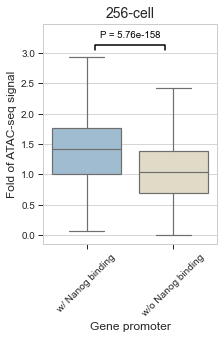

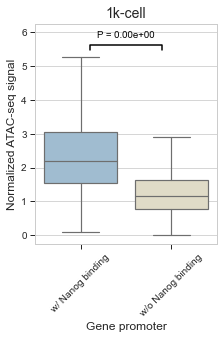

In [11]:
with sns.axes_style('whitegrid', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 14,
                             'axes.labelsize': 12,
                             'xtick.labelsize': 10,
                             'ytick.labelsize': 10,
                             'legend.fontsize': 10
                         }):

    fig, ax = plt.subplots(figsize=(6.4 * .5, 4.8))
    boxplot(
        x='Nanog_256_binding',
        y='256-cell',
        data=capture_signal.loc[[
            False if np.isnan(x) else True for x in capture_signal['256-cell']
        ], :],
        order=[True, False],
        palette=['#98BDD8', '#E4DDC3'],
        showfliers=False,
        statistic_args={
            'statistic_test': 'mannwhitneyu',
            'use_continuity': False,
        },
        ax=ax,
    )

    ax.set_xticklabels(labels=['w/ Nanog binding', 'w/o Nanog binding'],
                       rotation=45)
    ax.set_xlabel('Gene promoter')
    ax.set_ylabel('Fold of ATAC-seq signal')
    ax.set_title('256-cell')
    fig.tight_layout()
    fig.savefig('/mnt/Storage/home/wangyiman/fitCUTRUN/revision_1/analysis/figures/Supple_Fig5C_boxplot_atac_differenct_on_promoter_256.pdf',
                transparent=True)

    fig, ax = plt.subplots(figsize=(6.4 * .5, 4.8))
    boxplot(
        x='Nanog_1k_binding',
        y='1k-cell',
        data=capture_signal.loc[[
            False if np.isnan(x) else True for x in capture_signal['1k-cell']
        ], :],
        order=[True, False],
        palette=['#98BDD8', '#E4DDC3'],
        showfliers=False,
        statistic_args={
            'statistic_test': 'mannwhitneyu',
            'use_continuity': False,
        },
        ax=ax,
    )

    ax.set_xticklabels(labels=['w/ Nanog binding', 'w/o Nanog binding'],
                       rotation=45)
    ax.set_xlabel('Gene promoter')
    ax.set_ylabel('Normalized ATAC-seq signal')
    ax.set_title('1k-cell')
    fig.tight_layout()
    fig.savefig('/mnt/Storage/home/wangyiman/fitCUTRUN/revision_1/analysis/figures/Supple_Fig4C_boxplot_atac_differenct_on_promoter_1k.pdf',
                transparent=True)
    

# ATAC-seq signal change after nanog-rFc injection

In [11]:
%%bash
bigWigAverageOverBed ATAC_WT_256.bw <(cut -f 1-4 atac_wt_256_GR2018_peaks_p10f10.bed) atac_256_peaks_wt_256_signal.tsv
bigWigAverageOverBed  ATAC_WT_1k.bw <(cut -f 1-4 atac_wt_256_GR2018_peaks_p10f10.bed)  atac_256_peaks_wt_1k_signal.tsv

bigWigAverageOverBed    ATAC_WT_256.bw <(cut -f 1-4 atac_wt_1k_GR2018_peaks_p10f10.bed)    atac_1k_peaks_wt_256_signal.tsv
bigWigAverageOverBed     ATAC_WT_1k.bw <(cut -f 1-4 atac_wt_1k_GR2018_peaks_p10f10.bed)     atac_1k_peaks_wt_1k_signal.tsv
bigWigAverageOverBed ATAC_WT_oblong.bw <(cut -f 1-4 atac_wt_1k_GR2018_peaks_p10f10.bed) atac_1k_peaks_wt_oblong_signal.tsv

bigWigAverageOverBed     ATAC_WT_1k.bw <(cut -f 1-4 atac_wt_oblong_GR2018_peaks_p10f10.bed)     atac_oblong_peaks_wt_1k_signal.tsv
bigWigAverageOverBed ATAC_WT_oblong.bw <(cut -f 1-4 atac_wt_oblong_GR2018_peaks_p10f10.bed) atac_oblong_peaks_wt_oblong_signal.tsv

bigWigAverageOverBed ATAC_NanogFC_256.bw <(cut -f 1-4 atac_wt_256_GR2018_peaks_p10f10.bed) atac_256_peaks_NanogFC_256_signal.tsv
bigWigAverageOverBed  ATAC_NanogFC_1k.bw <(cut -f 1-4 atac_wt_256_GR2018_peaks_p10f10.bed)  atac_256_peaks_NanogFC_1k_signal.tsv

bigWigAverageOverBed    ATAC_NanogFC_256.bw <(cut -f 1-4 atac_wt_1k_GR2018_peaks_p10f10.bed)    atac_1k_peaks_NanogFC_256_signal.tsv
bigWigAverageOverBed     ATAC_NanogFC_1k.bw <(cut -f 1-4 atac_wt_1k_GR2018_peaks_p10f10.bed)     atac_1k_peaks_NanogFC_1k_signal.tsv
bigWigAverageOverBed ATAC_NanogFC_oblong.bw <(cut -f 1-4 atac_wt_1k_GR2018_peaks_p10f10.bed) atac_1k_peaks_NanogFC_oblong_signal.tsv

bigWigAverageOverBed     ATAC_NanogFC_1k.bw <(cut -f 1-4 atac_wt_oblong_GR2018_peaks_p10f10.bed)     atac_oblong_peaks_NanogFC_1k_signal.tsv
bigWigAverageOverBed ATAC_NanogFC_oblong.bw <(cut -f 1-4 atac_wt_oblong_GR2018_peaks_p10f10.bed) atac_oblong_peaks_NanogFC_oblong_signal.tsv

bigWigAverageOverBed atac_wt_256_GR2018.bw <(cut -f 1-4 atac_wt_256_GR2018_peaks_p10f10.bed) atac_256_peaks_WT_GR2018_256_signal.tsv
bigWigAverageOverBed  atac_wt_1k_GR2018.bw <(cut -f 1-4 atac_wt_256_GR2018_peaks_p10f10.bed)  atac_256_peaks_WT_GR2018_1k_signal.tsv

bigWigAverageOverBed    atac_wt_256_GR2018.bw <(cut -f 1-4 atac_wt_1k_GR2018_peaks_p10f10.bed)    atac_1k_peaks_WT_GR2018_256_signal.tsv
bigWigAverageOverBed     atac_wt_1k_GR2018.bw <(cut -f 1-4 atac_wt_1k_GR2018_peaks_p10f10.bed)     atac_1k_peaks_WT_GR2018_1k_signal.tsv
bigWigAverageOverBed atac_wt_oblong_GR2018.bw <(cut -f 1-4 atac_wt_1k_GR2018_peaks_p10f10.bed) atac_1k_peaks_WT_GR2018_oblong_signal.tsv

bigWigAverageOverBed     atac_wt_1k_GR2018.bw <(cut -f 1-4 atac_wt_oblong_GR2018_peaks_p10f10.bed)     atac_oblong_peaks_WT_GR2018_1k_signal.tsv
bigWigAverageOverBed atac_wt_oblong_GR2018.bw <(cut -f 1-4 atac_wt_oblong_GR2018_peaks_p10f10.bed) atac_oblong_peaks_WT_GR2018_oblong_signal.tsv


processing chromosomes
processing chromosomes
processing chromosomes
processing chromosomes
processing chromosomes
processing chromosomes
processing chromosomes
processing chromosomes
processing chromosomes
processing chromosomes
processing chromosomes
processing chromosomes
processing chromosomes
processing chromosomes
processing chromosomes


In [33]:
signal = {}

signal['256_peak'] = pd.DataFrame(index=pd.read_csv(
    'atac_256_peaks_wt_1k_signal.tsv',
    sep='\t',
    header=None,
    names=['size', 'covered', 'sum', 'mean0', 'mean']).index)
signal['256_peak']['WT_256'] = pd.read_csv(
    'atac_256_peaks_wt_256_signal.tsv',
    sep='\t',
    header=None,
    names=['size', 'covered', 'sum', 'mean0', 'mean'])['mean0'] / get_bigwig_mean('ATAC_WT_256.bw')
signal['256_peak']['WT_1k'] = pd.read_csv(
    'atac_256_peaks_wt_1k_signal.tsv',
    sep='\t',
    header=None,
    names=['size', 'covered', 'sum', 'mean0', 'mean'])['mean0'] / get_bigwig_mean('ATAC_WT_1k.bw')
signal['256_peak']['NanogFC_256'] = pd.read_csv(
    'atac_256_peaks_NanogFC_256_signal.tsv',
    sep='\t',
    header=None,
    names=['size', 'covered', 'sum', 'mean0', 'mean'])['mean0'] / get_bigwig_mean('ATAC_NanogFC_256.bw')
signal['256_peak']['NanogFC_1k'] = pd.read_csv(
    'atac_256_peaks_NanogFC_1k_signal.tsv',
    sep='\t',
    header=None,
    names=['size', 'covered', 'sum', 'mean0', 'mean'])['mean0'] / get_bigwig_mean('ATAC_NanogFC_1k.bw')
signal['256_peak']['WT_GR2018_256'] = pd.read_csv(
    'atac_256_peaks_WT_GR2018_256_signal.tsv',
    sep='\t',
    header=None,
    names=['size', 'covered', 'sum', 'mean0', 'mean'])['mean0'] / get_bigwig_mean('atac_wt_256_GR2018.bw')
signal['256_peak']['WT_GR2018_1k'] = pd.read_csv(
    'atac_256_peaks_WT_GR2018_256_signal.tsv',
    sep='\t',
    header=None,
    names=['size', 'covered', 'sum', 'mean0', 'mean'])['mean0'] / get_bigwig_mean('atac_wt_1k_GR2018.bw')

signal['1k_peak'] = pd.DataFrame(index=pd.read_csv(
    'atac_1k_peaks_wt_1k_signal.tsv',
    sep='\t',
    header=None,
    names=['size', 'covered', 'sum', 'mean0', 'mean']).index)
signal['1k_peak']['WT_256'] = pd.read_csv(
    'atac_1k_peaks_wt_256_signal.tsv',
    sep='\t',
    header=None,
    names=['size', 'covered', 'sum', 'mean0', 'mean'])['mean0'] / get_bigwig_mean('ATAC_WT_256.bw')
signal['1k_peak']['WT_1k'] = pd.read_csv(
    'atac_1k_peaks_wt_1k_signal.tsv',
    sep='\t',
    header=None,
    names=['size', 'covered', 'sum', 'mean0', 'mean'])['mean0'] / get_bigwig_mean('ATAC_WT_1k.bw')
signal['1k_peak']['WT_oblong'] = pd.read_csv(
    'atac_1k_peaks_wt_oblong_signal.tsv',
    sep='\t',
    header=None,
    names=['size', 'covered', 'sum', 'mean0', 'mean'])['mean0'] / get_bigwig_mean('ATAC_WT_oblong.bw')
signal['1k_peak']['NanogFC_256'] = pd.read_csv(
    'atac_1k_peaks_NanogFC_256_signal.tsv',
    sep='\t',
    header=None,
    names=['size', 'covered', 'sum', 'mean0', 'mean'])['mean0'] / get_bigwig_mean('ATAC_NanogFC_256.bw')
signal['1k_peak']['NanogFC_1k'] = pd.read_csv(
    'atac_1k_peaks_NanogFC_1k_signal.tsv',
    sep='\t',
    header=None,
    names=['size', 'covered', 'sum', 'mean0', 'mean'])['mean0'] / get_bigwig_mean('ATAC_NanogFC_1k.bw')
signal['1k_peak']['NanogFC_oblong'] = pd.read_csv(
    'atac_1k_peaks_NanogFC_oblong_signal.tsv',
    sep='\t',
    header=None,
    names=['size', 'covered', 'sum', 'mean0', 'mean'])['mean0'] / get_bigwig_mean('ATAC_NanogFC_oblong.bw')
signal['1k_peak']['WT_GR2018_256'] = pd.read_csv(
    'atac_1k_peaks_WT_GR2018_256_signal.tsv',
    sep='\t',
    header=None,
    names=['size', 'covered', 'sum', 'mean0', 'mean'])['mean0'] / get_bigwig_mean('atac_wt_256_GR2018.bw')
signal['1k_peak']['WT_GR2018_1k'] = pd.read_csv(
    'atac_1k_peaks_WT_GR2018_1k_signal.tsv',
    sep='\t',
    header=None,
    names=['size', 'covered', 'sum', 'mean0', 'mean'])['mean0'] / get_bigwig_mean('atac_wt_1k_GR2018.bw')
signal['1k_peak']['WT_GR2018_oblong'] = pd.read_csv(
    'atac_1k_peaks_WT_GR2018_oblong_signal.tsv',
    sep='\t',
    header=None,
    names=['size', 'covered', 'sum', 'mean0', 'mean'])['mean0'] / get_bigwig_mean('atac_wt_oblong_GR2018.bw')

signal['oblong_peak'] = pd.DataFrame(index=pd.read_csv(
    'atac_oblong_peaks_wt_1k_signal.tsv',
    sep='\t',
    header=None,
    names=['size', 'covered', 'sum', 'mean0', 'mean']).index)
signal['oblong_peak']['WT_1k'] = pd.read_csv(
    'atac_oblong_peaks_wt_1k_signal.tsv',
    sep='\t',
    header=None,
    names=['size', 'covered', 'sum', 'mean0', 'mean'])['mean0'] / get_bigwig_mean('ATAC_WT_1k.bw')
signal['oblong_peak']['WT_oblong'] = pd.read_csv(
    'atac_oblong_peaks_wt_oblong_signal.tsv',
    sep='\t',
    header=None,
    names=['size', 'covered', 'sum', 'mean0', 'mean'])['mean0'] / get_bigwig_mean('ATAC_WT_oblong.bw')
signal['oblong_peak']['NanogFC_1k'] = pd.read_csv(
    'atac_oblong_peaks_NanogFC_1k_signal.tsv',
    sep='\t',
    header=None,
    names=['size', 'covered', 'sum', 'mean0', 'mean'])['mean0'] / get_bigwig_mean('ATAC_NanogFC_1k.bw')
signal['oblong_peak']['NanogFC_oblong'] = pd.read_csv(
    'atac_oblong_peaks_NanogFC_oblong_signal.tsv',
    sep='\t',
    header=None,
    names=['size', 'covered', 'sum', 'mean0', 'mean'])['mean0'] / get_bigwig_mean('ATAC_NanogFC_oblong.bw')
signal['oblong_peak']['WT_GR2018_1k'] = pd.read_csv(
    'atac_oblong_peaks_WT_GR2018_1k_signal.tsv',
    sep='\t',
    header=None,
    names=['size', 'covered', 'sum', 'mean0', 'mean'])['mean0'] / get_bigwig_mean('atac_wt_1k_GR2018.bw')
signal['oblong_peak']['WT_GR2018_oblong'] = pd.read_csv(
    'atac_oblong_peaks_WT_GR2018_oblong_signal.tsv',
    sep='\t',
    header=None,
    names=['size', 'covered', 'sum', 'mean0', 'mean'])['mean0'] / get_bigwig_mean('atac_wt_oblong_GR2018.bw')

signal['oblong_peak'].head()

,WT_1k,WT_oblong,NanogFC_1k,NanogFC_oblong,WT_GR2018_1k,WT_GR2018_oblong
MACS_peak_13,42.690564,0.000000,6.419307,4.097851,2.520155,10.443455
MACS_peak_14,0.000000,3.948673,6.246063,6.831800,3.304499,8.552440
MACS_peak_16,0.000000,6.162915,5.078801,7.526710,2.469494,9.055029
MACS_peak_20,6.720507,6.428081,5.209010,4.154436,1.959008,8.633307
MACS_peak_22,0.000000,8.120442,1.974130,6.136514,3.244963,8.407341


In [63]:
signal_wo0 = {}
signal_wo0['256_peak'] = signal['256_peak'].loc[~(signal['256_peak'][['NanogFC_256','WT_256']]==0).any(axis=1)]
signal_wo0['256_peak']

,WT_256,WT_1k,NanogFC_256,NanogFC_1k,WT_GR2018_256,WT_GR2018_1k,log2fc,ov_nanog_dome,ov_nanog_256
MACS_peak_110,19.780017,10.264361,4.303614,13.461297,11.373293,11.373293,-2.174559,True,False
MACS_peak_169,5.937753,11.850957,4.140699,3.674251,10.086797,10.086797,-0.509710,False,False
MACS_peak_212,20.508492,41.505192,37.184138,37.944783,20.963779,20.963779,0.855323,False,False
MACS_peak_347,66.114137,154.387325,53.942475,39.728744,23.104505,23.104505,-0.293046,False,False
MACS_peak_356,38.102546,13.181616,6.908427,12.260390,14.394704,14.394704,-2.446506,False,False
...,...,...,...,...,...,...,...,...,...
MACS_peak_9508,599.804137,607.450833,871.776985,642.019264,180.496096,180.496096,0.539393,False,False
MACS_peak_9509,244.247807,172.374769,239.137667,165.043600,90.230742,90.230742,-0.030492,False,False
MACS_peak_9580,22.344101,11.594940,6.076843,2.102997,12.119557,12.119557,-1.861395,False,False
MACS_peak_9871,13.481366,6.995814,7.332967,3.253441,11.644657,11.644657,-0.869619,False,False


In [64]:
signal_wo0['1k_peak'] = signal['1k_peak'].loc[~(signal['1k_peak'][['NanogFC_1k','WT_1k']]==0).any(axis=1)]
signal_wo0['1k_peak']


,WT_256,WT_1k,WT_oblong,NanogFC_256,NanogFC_1k,NanogFC_oblong,WT_GR2018_256,WT_GR2018_1k,WT_GR2018_oblong,log2fc,ov_nanog_dome,ov_nanog_1k
MACS_peak_33,0.000000,5.111239,16.084301,0.000000,7.131040,7.006171,4.895710,14.196802,21.883421,0.472577,False,False
MACS_peak_36,0.000000,19.414773,2.321250,10.175203,0.316015,1.425674,2.043664,9.343779,4.578332,-5.551787,False,False
MACS_peak_56,8.097851,4.202195,10.048375,4.404685,15.634059,3.630302,7.832739,21.022806,26.950176,1.870746,True,True
MACS_peak_59,18.938746,4.544042,2.274237,0.000000,4.570497,8.977248,3.031392,7.486035,4.828741,0.008195,False,False
MACS_peak_62,0.000000,1.421770,5.230420,5.731883,3.560328,1.574723,2.221679,8.754313,2.434437,1.266223,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
MACS_peak_22293,0.000000,6.522149,1.933892,0.000000,12.132704,1.878184,3.051300,10.441335,5.586730,0.885372,False,False
MACS_peak_22300,8.278447,10.739717,9.204100,2.251458,6.992407,5.406080,5.135521,8.708379,6.949290,-0.611980,True,False
MACS_peak_22313,0.000000,3.841271,9.185318,0.000000,3.572805,9.955515,3.253682,11.338118,8.567331,-0.101779,False,False
MACS_peak_22321,8.711787,4.520753,13.923506,0.000000,6.307236,10.857396,3.762443,10.991683,14.194360,0.471574,False,False


## box plot -- Fig.S5D

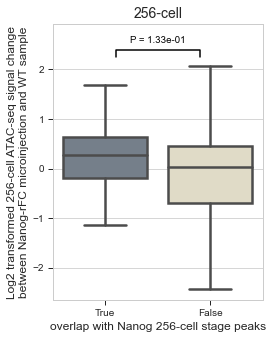

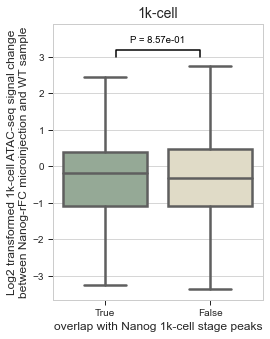

In [65]:
with sns.axes_style('whitegrid', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 14,
                             'axes.labelsize': 12,
                             'xtick.labelsize': 10,
                             'ytick.labelsize': 10,
                             'legend.fontsize': 10
                         }):
    
    
    fig, ax = plt.subplots(figsize=(6.4 * .6,4.8))
    boxplot(x='ov_nanog_256',
            y='log2fc',
            data=signal_wo0['256_peak'],
            order=[True,False],
            palette=['#727F8D','#E4DDC3'],
            linewidth=2.5,
            showfliers=False,
            statistic_args={
                'statistic_test': 'ttest_ind',
                'equal_var': False
            },
            ax=ax)
    ax.set_title('256-cell')
    ax.set_xlabel('overlap with Nanog 256-cell stage peaks')
    ax.set_ylabel('Log2 transformed 256-cell ATAC-seq signal change\nbetween Nanog-rFC microinjection and WT sample')
    fig.tight_layout()
    fig.savefig('/mnt/Storage/home/wangyiman/fitCUTRUN/revision_1/analysis/figures/Supple_Fig5B_Boxplot_NanogFC_injection_accessibility_change_256.pdf',
                transparent=True)

    
    fig, ax = plt.subplots(figsize=(6.4 * .6,4.8))
    boxplot(x='ov_nanog_1k',
            y='log2fc',
            data=signal_wo0['1k_peak'],
            order=[True,False],
            palette=['#92AC93','#E4DDC3'],
            linewidth=2.5,
            showfliers=False,
            statistic_args={
                'statistic_test': 'ttest_ind',
                'equal_var': False
            },
            ax=ax)
    ax.set_title('1k-cell')
    ax.set_xlabel('overlap with Nanog 1k-cell stage peaks')
    ax.set_ylabel('Log2 transformed 1k-cell ATAC-seq signal change\nbetween Nanog-rFC microinjection and WT sample')
    fig.tight_layout()
    fig.savefig('/mnt/Storage/home/wangyiman/fitCUTRUN/revision_1/analysis/figures/Supple_Fig5D_Boxplot_NanogFC_injection_accessibility_1k.pdf',
                transparent=True)

